In [65]:
#esse notebook contém os scripts para criar novos datasets;
import pandas as pd
import numpy as np
import time
import datetime
import re

years = [2015, 2016, 2017]
datapath = '../data/bicicletar/clean_data_'
files = [pd.read_pickle('%s%d.pkl' % (datapath,year)) for year in years]
# file2015 = 
# file2016 = pd.read_pickle(datapath+'2016.pkl')
# file2017 = pd.read_pickle(datapath+'2017.pkl')
all_data = pd.concat(files,ignore_index=True)
all_data['ano_nascimento'] = all_data['ano_nascimento'].astype('int64')

/home/renan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [17]:
#cria dataset com o número de viagens (de cada categoria) por ano (2014,2015,2016,2017)

def num_of_rides_per_year():
    date15 = datetime.datetime(2015, 1, 1)
    data2014 = all_data[all_data['datetime_retirada'] < date15]

    date16 = datetime.datetime(2016, 1, 1)
    data2015 = all_data[(date15 <= all_data['datetime_retirada']) & (all_data['datetime_retirada'] < date16)]

    date17 = datetime.datetime(2017, 1, 1)
    data2016 = all_data[(date16 <= all_data['datetime_retirada']) & (all_data['datetime_retirada'] < date17)]
    data2017 = all_data[date17 <= all_data['datetime_retirada']]

    data2014.shape[0],data2015.shape[0],data2016.shape[0],data2017.shape[0]

    #dataset = pd.DataFrame(columns=['bicicletar','minibicicletar','tecnica','menos_4_min','mais_um_dia','minibicicletar_bug'])
    dataset = []
    for data in[data2014,data2015,data2016,data2017]:
        dataset.append(data['tipo_viagem'].value_counts().to_dict())
    
    dataset = pd.DataFrame(dataset)
    dataset = dataset.rename(index=str, columns={0: 'bicicletar',
                                                 1: 'minibicicletar',
                                                 2: 'tecnica',
                                                 3: 'viagens curtas',
                                                 4: 'viagens longas',
                                                 5: 'minibicicletar com problema'})
    dataset = dataset.fillna(0)
    dataset['ano'] = [2014,2015,2016,2017]
    dataset = dataset.set_index('ano')
    dataset.to_csv('../data/bicicletar/graph_datasets/rides_per_years.csv')
        

In [6]:
#cria dataset com o número de cadastros (homem, mulher e outro) efetuados por ano (2014,2015,2016,2017)

def num_of_signup_per_year():
    dataset = all_data
    dataset['ano_cadastro'] = all_data.apply(lambda x: x['datetime_cadastro'].year, axis=1)
    dataM = dataset[dataset['sexo']=='M'].groupby(by='ano_cadastro', as_index=True).agg({'id_usuario': pd.Series.nunique})
    dataF = dataset[dataset['sexo']=='F'].groupby(by='ano_cadastro', as_index=True).agg({'id_usuario': pd.Series.nunique})
    dataO = dataset[dataset['sexo']=='O'].groupby(by='ano_cadastro', as_index=True).agg({'id_usuario': pd.Series.nunique})

    dataM = dataM.rename(columns={'id_usuario': 'M'})
    dataF = dataF.rename(columns={'id_usuario': 'F'})
    dataO = dataO.rename(columns={'id_usuario': 'O'})
    
    finalDS = pd.concat([dataM,dataF,dataO],axis=1)
    finalDS = finalDS.fillna(0);               
    
    finalDS.to_csv('../data/bicicletar/graph_datasets/signup_per_year.csv')
    return finalDS        

In [35]:
#cria dataset com o número de cadastros (homem, mulher e outro) efetuados por ano (2014,2015,2016,2017)

def num_of_rides_per_day():
    # bicicletar rides 
    dataset = all_data[all_data['tipo_viagem'] == 0]
    dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
    rides_per_day = pd.DataFrame(dataset['dia_corrida'].value_counts().sort_index())
    
    
    for ride_type in [1,2,3,4]:
        dataset = all_data[all_data['tipo_viagem'] == ride_type]
        dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
        a = pd.DataFrame(dataset['dia_corrida'].value_counts())
        a = a.rename(columns={'dia_corrida': ride_type})
        rides_per_day = pd.concat([rides_per_day,a], axis=1)
    
    rides_per_day = rides_per_day.fillna(0)
    
    rides_per_day = rides_per_day.rename(index=str, columns={'dia_corrida': 'bicicletar',
                                                             1: 'minibicicletar',
                                                             2: 'tecnica',
                                                             3: 'viagens curtas',
                                                             4: 'viagens longas',
                                                             5: 'minibicicletar com problema'})
    
    rides_per_day.index.name = 'dia'
    rides_per_day.to_csv('../data/bicicletar/graph_datasets/rides_per_day.csv')
    return rides_per_day    

In [ ]:
def num_of_users_birth_per_year(type):
    
    filter_data = all_data[(all_data['tipo_viagem'] == 0) & \
                           (all_data['ano_nascimento'] >= 1940) & \
                           (all_data['ano_nascimento'] <= 2000)]  
    
    m_data = filter_data[filter_data['sexo'] == 'M']
    f_data = filter_data[filter_data['sexo'] == 'F']
    o_data = filter_data[filter_data['sexo'] == 'O']
    
    m_perYear = m_data.groupby(by='ano_nascimento', as_index=True).agg({'id_usuario': pd.Series.nunique})
    f_perYear = f_data.groupby(by='ano_nascimento', as_index=True).agg({'id_usuario': pd.Series.nunique})
    o_perYear = o_data.groupby(by='ano_nascimento', as_index=True).agg({'id_usuario': pd.Series.nunique})

    
    m_perYear = m_perYear.rename(index=str, columns={'id_usuario': 'M'})
    f_perYear = f_perYear.rename(index=str, columns={'id_usuario': 'F'})
    o_perYear = o_perYear.rename(index=str, columns={'id_usuario': 'O'})
    
    m_perYear.plot.bar(figsize=(19,5))    
    f_perYear.plot.bar(figsize=(19,5))    
    o_perYear.plot.bar(figsize=(19,5))   
            
    final_dataset = pd.concat([m_perYear,f_perYear,o_perYear], axis=1)
    final_dataset.index.rename('year',inplace=True)
    final_dataset.fillna(0,inplace=True)

    if (type == 'perc'):
        ((final_dataset/final_dataset.sum().sum())*100).to_csv('../data/bicicletar/graph_datasets/perc_num_of_users_birth_per_year.csv')
    elif (type == 'abs'):
        final_dataset.to_csv('../data/bicicletar/graph_datasets/num_of_users_birth_per_year.csv')        
    return final_dataset

In [7]:
DS = num_of_signup_per_year()

In [2]:
viagens_bicicletar = all_data[all_data['tipo_viagem'] == 0]

viagens_bicicletar['tempo_viagem'] = (viagens_bicicletar['datetime_devolucao'] - viagens_bicicletar['datetime_retirada']) / np.timedelta64(1, 'h')
viagens_bicicletar['dia_retirada'] = viagens_bicicletar.apply(lambda x: x['datetime_retirada'].date(), axis=1)
viagens_bicicletar['dia_devolucao'] = viagens_bicicletar.apply(lambda x: x['datetime_devolucao'].date(), axis=1)
viagens_bicicletar.head(5)

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

,ano_nascimento,cidade,datetime_cadastro,datetime_devolucao,datetime_retirada,estacao_devolucao,estacao_retirada,id_bicicleta,id_usuario,pais,sexo,tipo_usuario,tipo_viagem,uf,tempo_viagem,dia_retirada,dia_devolucao
0,1989,NaN,2014-12-15 22:11:59,2014-12-16 06:33:31.307,2014-12-16 06:12:43.517,14,4,10561,1644398,BR,M,URA/APP,0,CE,0.346608,2014-12-16,2014-12-16
1,1985,NaN,2014-12-15 22:45:39,2014-12-16 07:08:10.530,2014-12-16 06:58:04.743,1,1,10460,1644548,BR,M,URA/APP,0,CE,0.168274,2014-12-16,2014-12-16
2,1995,NaN,2014-12-16 06:19:17,2014-12-16 07:34:38.240,2014-12-16 06:58:32.983,15,15,10464,1644977,BR,F,URA/APP,0,CE,0.601460,2014-12-16,2014-12-16
3,1987,fortaleza,2014-12-14 14:59:47,2014-12-16 07:52:22.063,2014-12-16 07:01:22.367,14,1,10637,1639126,BR,M,URA/APP,0,CE,0.849916,2014-12-16,2014-12-16
5,1980,NaN,2014-12-16 05:18:45,2014-12-16 07:26:16.473,2014-12-16 07:11:10.390,8,8,10556,1644927,BR,M,URA/APP,0,CE,0.251690,2014-12-16,2014-12-16


In [12]:
viagens_bicicletar['hora_retirada'] = viagens_bicicletar.apply(lambda x: x['datetime_retirada'].hour, axis=1)

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


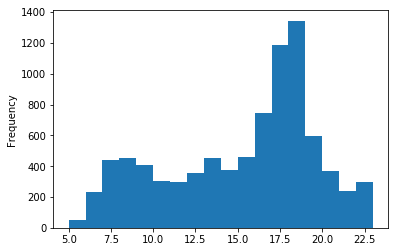

In [70]:
viagens_bicicletar[viagens_bicicletar['estacao_retirada']==70]['hora_retirada'].plot.hist(bins=18)

In [13]:
def num_of_rides_per_sex_type(ride_type):
    #ride_type = 0
    dataset = all_data[(all_data['sexo'] == 'M') & (all_data['tipo_viagem'] == ride_type)]
    dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
    rides_per_sex = pd.DataFrame(dataset['dia_corrida'].value_counts().sort_index())
    
    sex_rides = set(all_data['sexo'].unique()) - {'M'}
    
    for sex_type in sex_rides:
        print(sex_type)
        dataset = all_data[(all_data['sexo'] == sex_type) & (all_data['tipo_viagem'] == ride_type)]
        dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
        a = pd.DataFrame(dataset['dia_corrida'].value_counts())
        a = a.rename(columns={'dia_corrida': sex_type})
        rides_per_sex = pd.concat([rides_per_sex,a], axis=1)
    rides_per_sex = rides_per_sex.fillna(0)
    
    rides_per_sex['outros'] = rides_per_sex[list(sex_rides - {'F'})].sum(axis=1)

    rides_per_sex = rides_per_sex.rename(index=str, columns={'dia_corrida': 'M'})

    rides_per_sex = rides_per_sex.rename(index=str, columns={'M': 'M_%d' % ride_type,
                                                             'F': 'F_%d' % ride_type,
                                                             'outros': 'O_%d' % ride_type})

    rides_per_sex = rides_per_sex[['M_%d' % ride_type, 'F_%d' % ride_type, 'O_%d' % ride_type]]

    
#     rides_per_sex.to_csv('../data/bicicletar/graph_datasets/rides_per_sex.csv')
    return rides_per_sex

In [83]:
def num_of_rides_per_sex(ride_type):
    per_type_data = all_data[all_data['tipo_viagem'] == ride_type]
    per_type_data['dia_corrida'] = per_type_data.apply(lambda x: x['datetime_retirada'].date(), axis=1)

    per_sex_data = pd.DataFrame();

    for sex in ['M','F','O']:
        dataset = per_type_data[per_type_data['sexo'] == sex]
        a = pd.DataFrame(dataset['dia_corrida'].value_counts())
        a = a.rename(columns={'dia_corrida': '%s_%d' % (sex, ride_type)})
        per_sex_data = pd.concat([per_sex_data,a], axis=1)
    per_sex_data.index.name = 'dia'
    per_sex_data = per_sex_data.fillna(0)
    per_sex_data.to_csv('../data/bicicletar/graph_datasets/rides_per_sex_%s.csv' % ride_type)
    return per_sex_data

In [97]:
bb = pd.concat([num_of_rides_per_sex(ride_type) for ride_type in [0,3,4]], axis=1)
bb.index.name = 'dia'
bb = bb.fillna(0)
bb.to_csv('../data/bicicletar/graph_datasets/rides_per_sex.csv')

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will chan

In [62]:
def rides_between_neighborhood(ride_type, n=10):
    dataset = all_data
    rides_of_type = dataset[dataset['tipo_viagem'] == ride_type]
    st_nei = pd.read_csv('../data/bicicletar/stations_with_new_neighborhood.csv', index_col='id', usecols=['id', 'bairro'])
    rides_of_type['bairro_retirada'] = rides_of_type.apply(lambda x: st_nei.loc[x['estacao_retirada']]['bairro'], axis=1)
    rides_of_type['bairro_devolucao'] = rides_of_type.apply(lambda x: st_nei.loc[x['estacao_devolucao']]['bairro'], axis=1)
    rides_of_type['bairro_retirada'].value_counts().iloc[:10].index
    rides_of_type['bairro_devolucao'].value_counts().iloc[:10]
    topN_bairros = list(set(rides_of_type['bairro_retirada'].value_counts().iloc[:n].index).union(set(rides_of_type['bairro_devolucao'].value_counts().iloc[:n].index)))
    
    rides_topNbairros =   rides_of_type[rides_of_type['bairro_retirada'].isin(topN_bairros) & rides_of_type['bairro_devolucao'].isin(topN_bairros)]
    
    rides_topNbairros = rides_topNbairros[rides_topNbairros['bairro_devolucao'] != rides_topNbairros['bairro_retirada']]
    return rides_topNbairros[['bairro_devolucao','bairro_retirada']]

In [63]:
aa =  rides_between_neighborhood(0, 10)
(aa['bairro_devolucao'] + "," + aa['bairro_retirada']).value_counts().to_csv('../data/a.csv')

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
#cria dataset com o número de cadastros (homem, mulher e outro) efetuados por ano (2014,2015,2016,2017)

def num_of_rides_per_month():
    # bicicletar rides 
    dataset = all_data[all_data['tipo_viagem'] == 0]
    dataset['ano_corrida'] = dataset.apply(lambda x: '%d' % x['datetime_retirada'].year, axis=1)
    dataset['mes_corrida'] = dataset.apply(lambda x: '%s' % str(x['datetime_retirada'].month).zfill(2), axis=1)
    
    dataset['aaa'] = dataset['ano_corrida'] + dataset['mes_corrida']
    
    return dataset       

In [41]:
aa = num_of_rides_per_month()

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [65]:
final_data = pd.concat(aaa_sex,axis=1)
final_data['mes_ano'] = final_data.index
final_data['ano'] = final_data.apply(lambda x: str(x['mes_ano'])[:4], axis=1)
final_data['mes'] = final_data.apply(lambda x: str(x['mes_ano'])[4:], axis=1)
final_data = final_data[['ano','mes','M', 'F', 'O']]
final_data.to_csv('../data/bicicletar/graph_datasets/rides_per_month.csv', index=False)

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [56]:
aaa_sex = list()
for sexo in aa.sexo.unique():
    aa_per_sex = aa[aa['sexo'] == sexo]
    aaa_sex.append(pd.DataFrame(aa_per_sex['aaa'].value_counts()).rename(columns={'aaa': sexo}))

In [90]:
def num_


all_data['data_cadastro'] = pd.to_datetime(all_data['data_cadastro'])

date15 = datetime.datetime(2015, 1, 1)
data2014 = all_data[all_data['data_cadastro'] < date15]

date16 = datetime.datetime(2016, 1, 1)
data2015 = all_data[(date15 <= all_data['data_cadastro']) & (all_data['data_cadastro'] < date16)]

date17 = datetime.datetime(2017, 1, 1)
data2016 = all_data[(date16 <= all_data['data_cadastro']) & (all_data['data_cadastro'] < date17)]
data2017 = all_data[date17 <= all_data['data_cadastro']]
data2014.shape[0],data2015.shape[0],data2016.shape[0],data2017.shape[0]


(307830, 1059103, 365981, 103229)

In [186]:
all_data.loc[0]['datetime_retirada'].date()

datetime.date(2014, 12, 16)

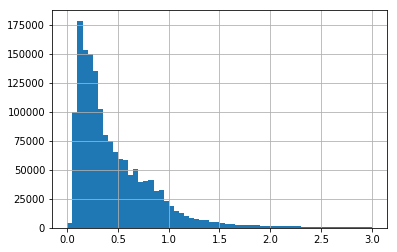

In [87]:
all_data['tempo_viagem'] = (all_data['datetime_devolucao'] - all_data['datetime_retirada']) / datetime.timedelta(hours=1)
data_bicicletar = all_data[all_data['tipo_viagem'] == 0]
data_bicicletar['tempo_viagem'][data_bicicletar['tempo_viagem'] <= 3].hist(bins=60)

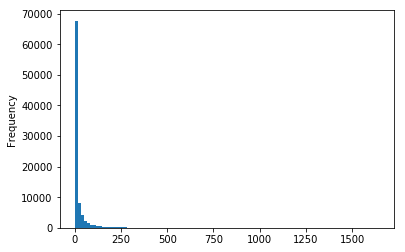

In [113]:
all_data['id_usuario'].value_counts().plot.hist(bins=100)

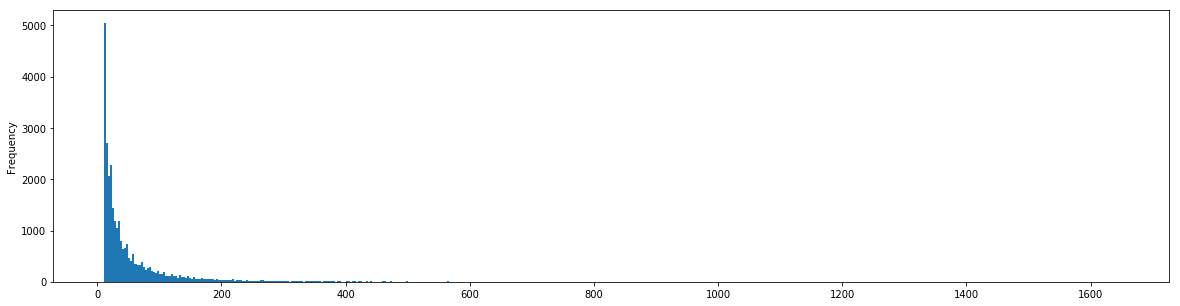

In [140]:
 all_data['id_usuario']

aa = all_data['id_usuario'].value_counts()
aa[aa > 10].plot.hist(bins=500, figsize=(20,5))

In [144]:
aa = pd.DataFrame(aa)

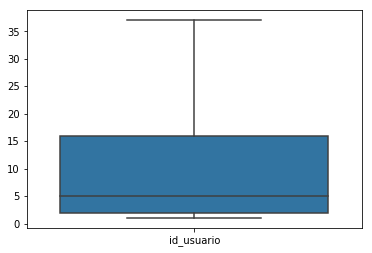

In [148]:
import seaborn as sns
sns.boxplot(data=aa,
                showfliers=False)

# aa.boxplot(figsize=(20,30))

In [151]:
all_data['data_cadastro'] = pd.to_datetime(all_data['data_cadastro'])

dataset = all_data
dataset['ano_cadastro'] = all_data.apply(lambda x: x['data_cadastro'].year, axis=1)
D2014 = dataset[dataset['ano_cadastro'] == 2008]

aa = D2014.groupby(by='sexo', as_index=True).agg({'id_usuario': pd.Series.nunique})

#dataset = dataset.rename(columns={'id_usuario': 'numero_de_cadastros'})
    
#dataset.to_csv('../data/bicicletar/graph_datasets/signup_per_year.csv')

In [175]:
summm = 0
for year in [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]:
    D2014 = dataset[dataset['ano_cadastro'] == year]
    aa = D2014.groupby(by='sexo', as_index=True).agg({'id_usuario': pd.Series.nunique})
    print(aa)
    print('Ano: %d; Total %d' %(year,sum(aa['id_usuario'])))
    summm +=sum(aa['id_usuario'])
    print()
    
    
print('TOTAL',summm)

      id_usuario
sexo            
F              1
M              1
Ano: 2008; Total 2

      id_usuario
sexo            
F              8
M             14
Ano: 2009; Total 22

      id_usuario
sexo            
F             15
M             20
Ano: 2010; Total 35

      id_usuario
sexo            
F             39
M             61
Ano: 2011; Total 100

      id_usuario
sexo            
F            284
M            457
Ano: 2012; Total 741

      id_usuario
sexo            
F            516
M            715
O              1
Ano: 2013; Total 1232

      id_usuario
sexo            
-              3
F           5113
M           6056
O             22
Ano: 2014; Total 11194

      id_usuario
sexo            
-              3
F          21825
M          21259
O             91
Ano: 2015; Total 43178

      id_usuario
sexo            
F           9873
M          10575
O            105
Ano: 2016; Total 20553

      id_usuario
sexo            
0              1
-              1
F           5416


In [163]:
3+5113+6056+22

11194

In [177]:
all_data['id_usuario'].unique().shape

(88433,)

In [16]:

#dataset = dataset.rename(columns={'id_usuario': 'numero_de_cadastros'})

In [30]:
finalDS

,M,F,O
ano_cadastro,,,
2008,1,1,0.0
2009,14,8,0.0
2010,20,15,0.0
2011,61,39,0.0
2012,457,284,0.0
2013,715,516,1.0
2014,6056,5113,25.0
2015,21259,21825,94.0
2016,10575,9873,105.0


In [12]:
dataset1 = aaa.groupby(by='ano_cadastro', as_index=True).agg({'id_usuario': pd.Series.nunique})

In [13]:
dataset1

,id_usuario
ano_cadastro,
2008,1
2009,14
2010,20
2011,61
2012,457
2013,715
2014,6056
2015,21259
2016,10575


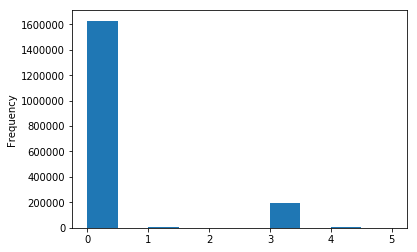

In [9]:
# all_data['tipo_viagem'].value_counts()
aa = all_data['tipo_viagem'].plot.hist()

In [136]:
def num_of_rides_per_birth_year(type):
    fData = all_data[(all_data['tipo_viagem'] == 0) & \
                     (all_data['ano_nascimento'] >= 1940) & \
                     (all_data['ano_nascimento'] <= 2000)] 
    
    m_data = fData[fData['sexo'] == 'M']['ano_nascimento'].value_counts()
    f_data = fData[fData['sexo'] == 'F']['ano_nascimento'].value_counts()
    o_data = fData[fData['sexo'] == 'O']['ano_nascimento'].value_counts()
    
    final_dataset = pd.concat([m_data,f_data,o_data], axis=1)    
    final_dataset.index.rename('year',inplace=True)
    final_dataset.fillna(0,inplace=True)
    
    final_dataset.columns = ['M','F','O']
    
    if (type == 'perc'):
        ((final_dataset/final_dataset.sum().sum())*100).to_csv('../data/bicicletar/graph_datasets/perc_num_of_rides_per_birth_year.csv')
    elif (type == 'abs'):
#         final_dataset.to_csv('../data/bicicletar/graph_datasets/num_of_users_birth_per_year.csv')        
        final_dataset.to_csv('../data/bicicletar/graph_datasets/num_of_rides_per_birth_year.csv')
    

In [137]:
num_of_rides_per_birth_year('perc')

In [128]:
fd


,M,F,O
year,,,
1940,64,1,0.0
1941,2,8,2.0
1942,63,70,0.0
1943,159,70,0.0
1944,141,13,1.0
1945,263,182,0.0
1946,431,21,0.0
1947,203,43,0.0
1948,328,193,0.0
